Carga de paquetes

In [42]:
import pywt
import pywt.data
from PIL import Image
import numpy as np
import cv2 # Para leer imagenes y meterles bordes, contornos y cosas
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.ndimage import rotate
try:
 from PIL import Image
except ImportError:
 import Image

import keras
import tensorflow
import random

In [43]:
# Carga imagen
image_path = "data\images\WhatsApp Image 2023-11-19 at 17.21.41.jpeg"
image = Image.open(image_path)

In [44]:
# Convertir a escala de grises y a matriz de Numpy
grayscale_original = image.convert("L")
img_orig = np.array(grayscale_original)
alt, anch = img_orig.shape
print(alt, anch)
img_orig = rotate(img_orig, 90, reshape = True)
img_origr = img_orig.copy()

2016 1512


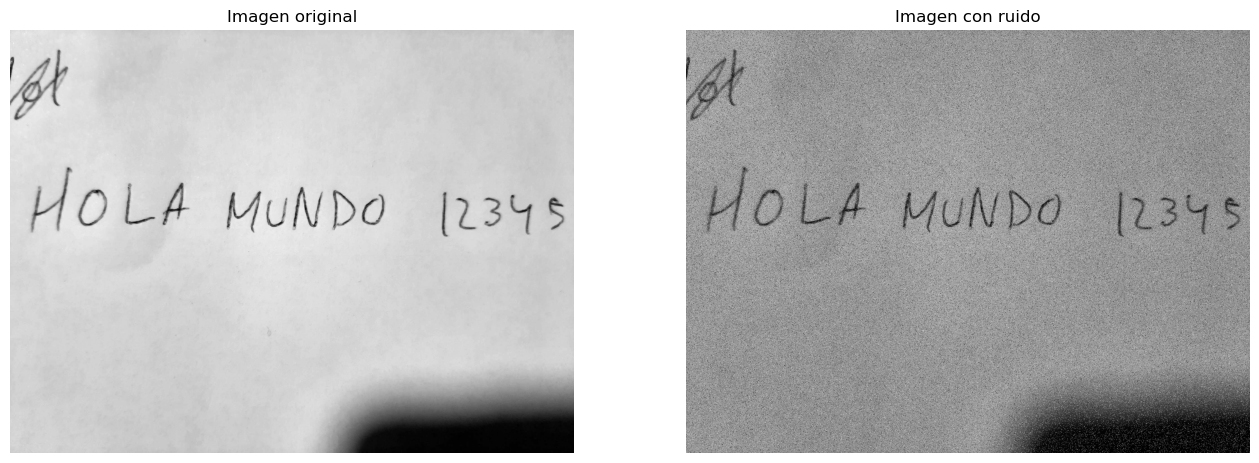

In [45]:
# Meter ruido a la imagen
def sp_noise(image,prob):
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

noise_img = sp_noise(img_origr,0.05)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_orig, cmap='gray')
plt.title('Imagen original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(noise_img, cmap='gray')
plt.title('Imagen con ruido')
plt.axis('off')

plt.show()

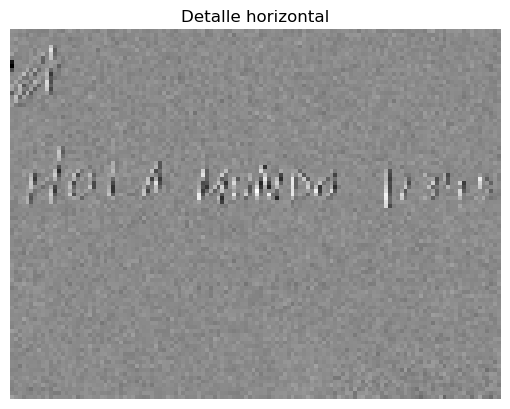

In [46]:
# Wavelet multinivel con RUIDO
multi_lvl = 4
coeffsr = pywt.wavedec2(noise_img, 'haar', level = multi_lvl)
LLr = coeffsr[0]
# seleccionar nivel de detalles deseados desde 1 hasta multi_lvl
(LHr, HLr, HHr) = coeffsr[1]

#HLr = rotate(HLr, 90, reshape = True) #SOLO SI LA IMAGEN ESTÁ ROTADA
plt.imshow(HLr, cmap='gray')
plt.title('Detalle horizontal')
plt.axis('off')
plt.show()

In [47]:
# Wavelet multinivel original
coeffs = pywt.wavedec2(img_orig, 'haar', level = multi_lvl)

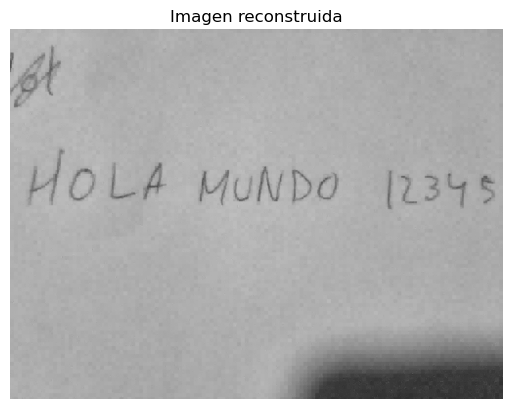

In [48]:
# PARÁMETROS OPCIONALES

# Level coeffs
# print(len(coeffs) - 1)

# Seleccionar que detalles no se quieren en la reconstrucción(aqui quito los detalles del nivel 1)
# eli_lvl = 1
# coeffs[-eli_lvl] = tuple([np.zeros_like(v) for v in coeffs[-eli_lvl]])

# Thresholding (se puede seleccionar "soft" o "hard" para imputar valores en los coeficientes que eliminen el ruido)
threshold_function = lambda x: pywt.threshold(x, 100, mode="soft")
coeffs_thresholded = [tuple(map(threshold_function, coeff)) for coeff in coeffsr]

# Reconstrucción imagen
img_rec = pywt.waverec2(coeffs_thresholded, 'haar')
plt.imshow(img_rec, cmap='gray')
plt.title('Imagen reconstruida')
plt.axis('off')
plt.show()

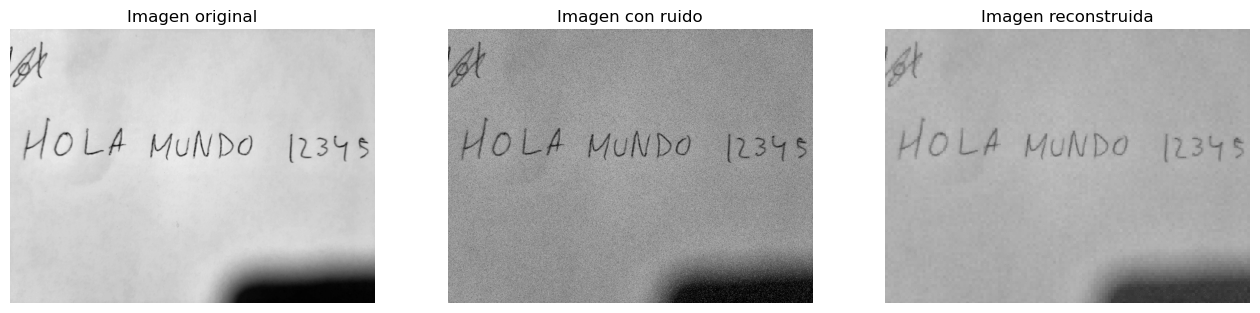

In [49]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(img_orig, cmap='gray')
plt.title('Imagen original')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(noise_img, cmap='gray')
plt.title('Imagen con ruido')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(img_rec, cmap='gray')
plt.title('Imagen reconstruida')
plt.axis('off')

plt.show()

In [50]:
cA = img_orig
normalized_cA = (cA - np.min(cA)) / (np.max(cA) - np.min(cA))
inverted_cA = 1 - normalized_cA
threshold_value = (np.max(inverted_cA) - np.min(inverted_cA)) * 0.3

mask = (inverted_cA >= threshold_value).astype(np.uint8) * 255
masked_image = cv2.bitwise_and(inverted_cA, inverted_cA, mask=mask)

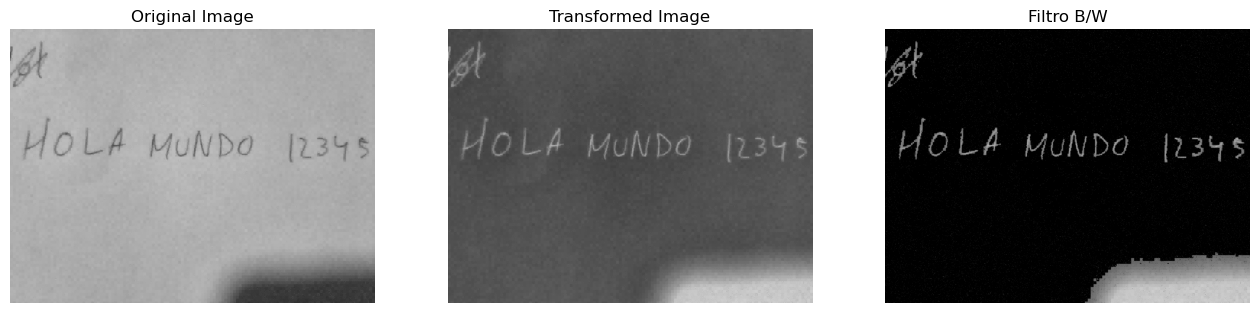

In [51]:
# Filtros aplicados a la imagen reconstruida
cAr = img_rec
normalized_cAr = (cAr - np.min(cAr)) / (np.max(cAr) - np.min(cAr))
inverted_cAr = 1 - normalized_cAr
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(img_rec, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(inverted_cAr, cmap='gray')
plt.title('Transformed Image')
plt.axis('off')

threshold_value = (np.max(inverted_cAr) - np.min(inverted_cAr)) * 0.4 # Cambiar valor del umbral hasta que sea blanco sobre negro

mask = (inverted_cAr >= threshold_value).astype(np.uint8) * 255
masked_imager = cv2.bitwise_and(inverted_cAr, inverted_cAr, mask=mask)
plt.subplot(1, 3, 3)
plt.imshow(masked_imager, cmap='gray')
plt.title('Filtro B/W')
plt.axis('off')

plt.show()


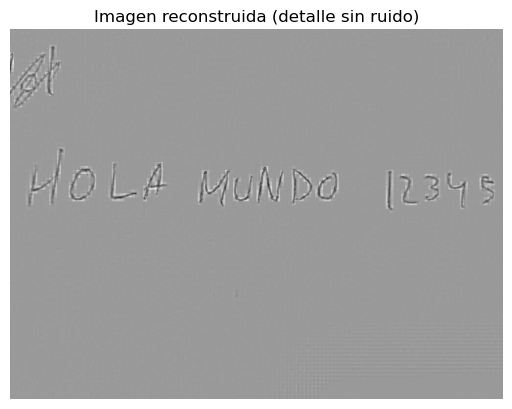

In [52]:
# Wavelet para reconstruir la imagen solo con los niveles de detalles SIN RUIDO
coeffs[0] = np.zeros_like(coeffs[0])
img_recb = pywt.waverec2(coeffs, 'haar',)
plt.imshow(img_recb, cmap='gray')
plt.title('Imagen reconstruida (detalle sin ruido)')
plt.axis('off')
plt.show()

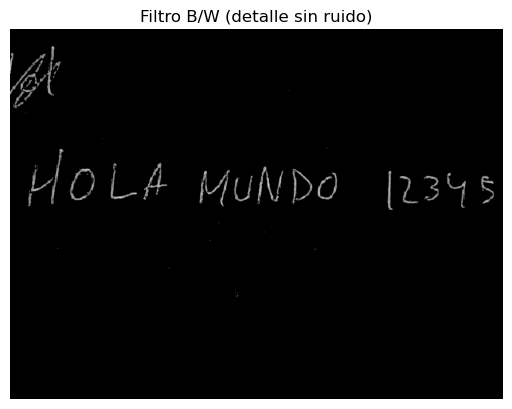

In [53]:
cAb = img_recb
normalized_cAb = (cAb - np.min(cAb)) / (np.max(cAb) - np.min(cAb))
inverted_cAb = 1 - normalized_cAb

threshold_value = (np.max(inverted_cAb) - np.min(inverted_cAb)) * 0.45 # Cambiar valor del umbral hasta que sea blanco sobre negro

mask = (inverted_cAb >= threshold_value).astype(np.uint8) * 255
masked_imageb= cv2.bitwise_and(inverted_cAb, inverted_cAb, mask=mask)
plt.imshow(masked_imageb, cmap='gray')
plt.title('Filtro B/W (detalle sin ruido)')
plt.axis('off')

plt.show()

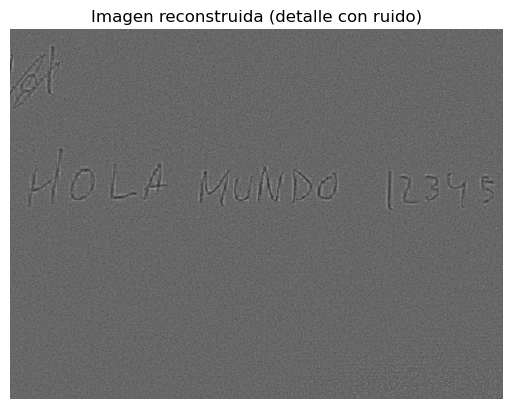

In [54]:
# Wavelet para reconstruir la imagen solo con los niveles de detalles CON RUIDO
coeffsr[0] = np.zeros_like(coeffsr[0])
#threshold_function = lambda x: pywt.threshold(x, 100, mode="soft") #Debería suavizar el ruido, pero va peor para la detección de las letras
#coeffsr2 = [tuple(map(threshold_function, coeff)) for coeff in coeffsr]
img_recbr = pywt.waverec2(coeffsr, 'haar',)
plt.imshow(img_recbr, cmap='gray')
plt.title('Imagen reconstruida (detalle con ruido)')
plt.axis('off')
plt.show()

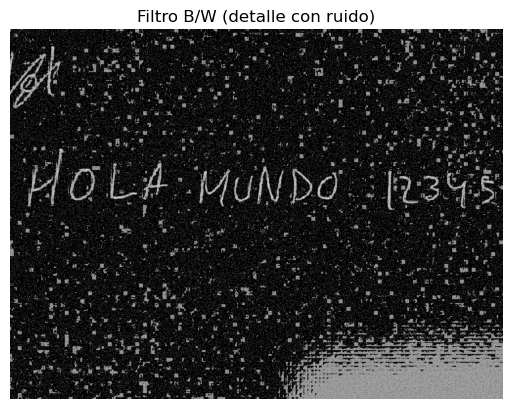

In [55]:
cAbr = img_recbr
normalized_cAbr = (cAbr - np.min(cAbr)) / (np.max(cAbr) - np.min(cAbr))
inverted_cAbr = 1 - normalized_cAbr

threshold_value = (np.max(inverted_cAbr) - np.min(inverted_cAbr)) * 0.6 # Cambiar valor del umbral hasta que sea blanco sobre negro

mask = (inverted_cAbr >= threshold_value).astype(np.uint8) * 255
masked_imagebr= cv2.bitwise_and(inverted_cAbr, inverted_cAbr, mask=mask)
plt.imshow(masked_imagebr, cmap='gray')
plt.title('Filtro B/W (detalle con ruido)')
plt.axis('off')

plt.show()

1/1 [==============================] - 0s 15ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

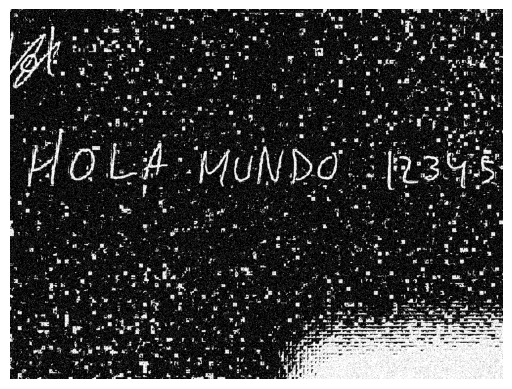

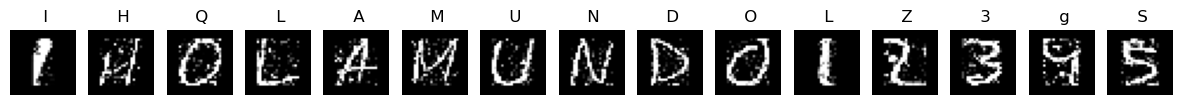

In [56]:
# Carga de la red neuronal previamente entrenada

ed_model_02 = tensorflow.keras.models.load_model('modelos\modelo_C_04.keras')

# Posibles etiquetas de resultado

LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']

index_to_label = {i: label for i, label in enumerate(LABELS)}

# ESCOGER ENTRE "masked_image" para la original, "masked_imager" para la reconstruida sin ruido, "masked_imageb" 
# para la reconstruida usando solo los niveles de detalle sin ruido y "masked_imagebr" para la reconstruida usando solo niveles de detalle con ruido.

#------------------------------
chosen_one = masked_imagebr
#------------------------------

_, binary_imagec = cv2.threshold(chosen_one, .2, 1, cv2.THRESH_BINARY)
binary_imagec = np.uint8(binary_imagec)


_, binary_image = cv2.threshold(masked_image, .2, 1, cv2.THRESH_BINARY)
binary_image = np.uint8(binary_image)
plt.imshow(binary_imagec, cmap="gray")
plt.axis("off")
plt.show
regiones_recortadas = []
_, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image)

# Iterar a través de los componentes conectados y filtrar por ciertas estadísticas
for i, stat in enumerate(stats):
    # Filtrar componentes conectados basados en ciertas estadísticas (área, posición, etc.)
    # Por ejemplo, puedes filtrar por el área para eliminar componentes pequeños o grandes
    area = stat[cv2.CC_STAT_AREA]
    if area > 25 and area < 10000:  # Cambia estos valores según tus necesidades
        # Dibujar un rectángulo alrededor del componente conectado
        x, y, w, h = stat[cv2.CC_STAT_LEFT], stat[cv2.CC_STAT_TOP], stat[cv2.CC_STAT_WIDTH], stat[cv2.CC_STAT_HEIGHT]
        # cv2.rectangle(edged_image, (x, y), (x + w, y + h), (255, 0, 0), 2) #Diguja los rectángulos en la imagen

        # Recortar la región del rectángulo de la imagen original
        roi = binary_imagec[y:y+h, x:x+w]
        centroide = centroids[i]
        regiones_recortadas.append((roi, centroide))

# Ordenar las regiones por las coordenadas de los centroides
regiones_ordenadas = sorted(regiones_recortadas, key=lambda x: (x[1][0], x[1][1]))
fig, axs = plt.subplots(1, len(regiones_ordenadas), figsize=(15, 3))

# Guardar las letras en orden de aparición en la carpeta "fotos"
for i, (region, _) in enumerate(regiones_ordenadas):

    border_size = int(region.shape[0] * .2)  #Porcentaje del 20 % del tamaño de la imagen como borde

    # Crea el borde negro alrededor de la imagen
    image_with_border = cv2.copyMakeBorder(
    region,
    top=border_size,
    bottom=border_size,
    left=border_size,
    right=border_size,
    borderType=cv2.BORDER_CONSTANT,
    value=[0, 0, 0]
    )
    resized_matrix = resize(image_with_border, (28, 28), anti_aliasing=False)
    imagen_array = np.array(resized_matrix).reshape(1, 784)
    imagen_normalizada = imagen_array.astype('float32')
    normalized_image = (imagen_normalizada - np.min(imagen_normalizada)) / (np.max(imagen_normalizada) - np.min(imagen_normalizada))
    prediction = ed_model_02.predict(normalized_image)
    predicted_class = np.argmax(prediction)
    predicted_label = index_to_label[predicted_class]
    axs[i].imshow(imagen_normalizada.reshape(28, 28), cmap='gray')
    axs[i].axis('off')  # Turn off axis labels
    axs[i].set_title(f' {predicted_label}')
plt.show